# Assignment 8

## 2. Market capitalization and expected returns

In [1]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
db = wrds.Connection()
db.create_pgpass_file()

Enter your WRDS username [felicity]:alina925
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [3]:
# get rf
rf=db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1980-01-01' and mcaldt<='2019-12-31'")
rf.to_csv('rf.csv')
# get value-weighted CRSP market return
vwret = db.raw_sql("select date, vwretd from crsp.msi where date>='1980-01-01' and date<='2019-12-31'")
vwret.to_csv('vwret.csv')

In [4]:
rf = pd.read_csv('rf.csv', usecols=['tmytm']).squeeze()
#Compute the monthly simple rate
rf_m = np.exp(rf/12/100)-1

vwret = pd.read_csv('vwret.csv', usecols=['vwretd']).squeeze()

In [5]:
stocks = db.raw_sql("""
                select a.permno, a.date, a.ret, b.exchcd, b.shrcd, a.shrout, a.prc 

                from crsp.msf as a left join crsp.msenames as b 
                
                on a.permno = b.permno and b.namedt <= a.date and a.date<=b.nameendt
                
                where a.date between '1980-01-01' and '2019-12-31'
                and b.exchcd between 1 and 2
                and b.shrcd between 10 and 11""",date_cols=['date'])

stocks.to_csv('stocks.csv')

In [6]:
# change table format from long to wide
stocks_ret = pd.pivot_table(data=stocks, values='ret', index='date', columns='permno')
stocks_shrout = pd.pivot_table(data=stocks, values='shrout', index='date', columns='permno')
stocks_prc = pd.pivot_table(data=stocks, values='prc', index='date', columns='permno')

In [7]:
s = stocks_ret.apply(sum)
s = list(s.isna())
s_i = []
for i in range(len(s)):
    if not s[i]:
        s_i.append(i)

In [8]:
# removing stocks containing NaN values
stocks_ret = stocks_ret.iloc[:,s_i]
stocks_shrout = stocks_shrout.iloc[:,s_i]
stocks_prc = stocks_prc.iloc[:,s_i]

### b)

In [9]:
stocks_prc = stocks_prc.abs()

In [10]:
for j in range(stocks_shrout.shape[1]):
    for i in range(stocks_shrout.shape[0]):
        if pd.isna(stocks_shrout.iloc[i,j]) or pd.isnull(stocks_shrout.iloc[i,j]):
            if i == 0:
                s = 1
                while pd.isna(stocks_shrout.iloc[i+s,j]) or pd.isnull(stocks_shrout.iloc[i+s,j]):
                    s += 1
                stocks_shrout.iloc[i:(i+s+1),j] = stocks_shrout.iloc[i+s,j]
            else:
                stocks_shrout.iloc[i,j] = stocks_shrout.iloc[i-1,j]

In [11]:
for j in range(stocks_prc.shape[1]):
    for i in range(stocks_prc.shape[0]):
        if pd.isna(stocks_prc.iloc[i,j]) or pd.isnull(stocks_prc.iloc[i,j]):
            if i == 0:
                s = 1
                while pd.isna(stocks_prc.iloc[i+s,j]) or pd.isnull(stocks_prc.iloc[i+s,j]):
                    s += 1
                stocks_prc.iloc[i:(i+s+1),j] = stocks_prc.iloc[i+s,j]
            else:
                stocks_prc.iloc[i,j] = stocks_prc.iloc[i-1,j]

In [12]:
stocks_mcap = pd.DataFrame(stocks_shrout.values*stocks_prc.values, columns=stocks_shrout.columns, index=stocks_shrout.index)

In [13]:
last_mcap = stocks_mcap.iloc[len(stocks_mcap)-1,:]
permnos = np.array(last_mcap.index)
mcap_ord = np.array(np.argsort(last_mcap))
mcap_sort = np.sort(last_mcap)

In [16]:
len(mcap_ord)

271

In [29]:
#take the last one out, and put in the last group
last = mcap_sort[-1]
ord_last = mcap_ord[-1]
mcap_groups = np.reshape(mcap_sort[:-1],(10,27))
ord_groups = np.reshape(mcap_ord[:-1],(10,27))

In [60]:
vwret_e = vwret - rf_m
stocks_e = stocks_ret - rf_m
rf_m.index = stocks_ret.index
stocks_e = stocks_ret.subtract(rf_m, axis = 0)

In [90]:
#Equally weighted portfolio

alphas = []
betas = []
x = np.array(vwret_e).reshape((-1,1))

#mean excess return
avg_e = np.zeros(10)

for i in range(9):
    #equally weighted monthly return
    eq_ret = stocks_ret.iloc[:,ord_groups[i]].mean(axis=1)
    
    #equally weighted excess return
    eq_ret_e = eq_ret.subtract(rf_m, axis = 0)
    avg_e[i] = eq_ret_e.mean()
    
    #regression
    y = np.array(eq_ret_e).reshape((-1,1))
    lm = LinearRegression().fit(x,y)
    betas.append(lm.coef_.item())
    alphas.append(lm.intercept_.item()) 
         
    
group10 = np.append(ord_groups[9],ord_last)
eq_ret10 = stocks_ret.iloc[:,group10].mean(axis=1)    
eq_ret_e10 = eq_ret10.subtract(rf_m, axis = 0)
avg_e[9] = eq_ret_e10.mean()
y = np.array(eq_ret_e10).reshape((-1,1))
lm = LinearRegression().fit(x,y)
betas.append(lm.coef_.item())
alphas.append(lm.intercept_.item())



In [200]:
#Value weighted 

al = []
be = []
x = np.array(vwret_e).reshape((-1,1))
w = np.zeros((stocks_mcap.shape[0],27))

#mean excess return
avg_vw_e = np.zeros(10)

for i in range(9):
    #value weighted monthly return
    stocks_mcap.iloc[:,ord_groups[i]]
    for j in range(stocks_mcap.shape[0]):
        ww = stocks_mcap.iloc[j,ord_groups[i]]
        w[j,:] =np.reshape(np.array(ww)/ww.sum(),(1,27))
    
    vw_r = stocks_ret.iloc[:,ord_groups[i]] * w
    vw_ret = vw_r.sum(axis = 1)
    
    #value weighted excess return
    vw_ret_e = vw_ret.subtract(rf_m, axis = 0)
    avg_vw_e[i] = vw_ret_e.mean()
    
    #regression
    y = np.array(vw_ret_e).reshape((-1,1))
    lm = LinearRegression().fit(x,y)
    be.append(lm.coef_.item())
    al.append(lm.intercept_.item()) 
         
    
gr10 = np.append(ord_groups[9],ord_last)
for k in range(stocks_mcap.shape[0]):
        ww = stocks_mcap.iloc[j,ord_groups[9]]
        w[k,:] =np.reshape(np.array(ww)/ww.sum(),(1,27))
vw_r10 = stocks_ret.iloc[:,ord_groups[9]] * w
vw_ret10 = vw_r10.sum(axis = 1)
vw_ret_e10 = vw_ret10 - rf_m
avg_vw_e[9] = vw_ret_e10.mean()
y = np.array(vw_ret_e10).reshape((-1,1))
lm = LinearRegression().fit(x,y)
be.append(lm.coef_.item())
al.append(lm.intercept_.item())




Text(0.5, 0, 'Decile portfolio')

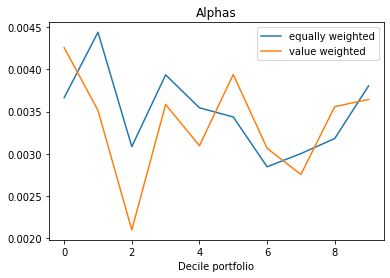

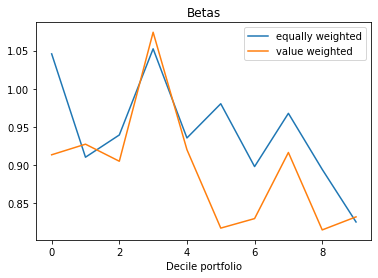

In [203]:
plt.figure()
plt.plot(alphas, label='equally weighted')
plt.plot(al, label='value weighted')
plt.legend()
plt.title('Alphas')
plt.xlabel('Decile portfolio')


plt.figure()
plt.plot(betas, label='equally weighted')
plt.plot(be, label='value weighted')
plt.legend()
plt.title('Betas')
plt.xlabel('Decile portfolio')